In [301]:
# import numpy as np
# import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go
# import streamlit as st

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

import streamlit as st


In [280]:
def read_data(tickers, start_date, end_date=dt.datetime.now().date()):
    return yf.download(tickers, start=start_date, end=end_date)['Adj Close']

def get_cols_by_substring(df, substring):
    return df.loc[:,[substring in i for i in df.columns]]

def run_ma_analysis(tickers, ma_params, breach_limit_alert, data):

    # Extract the tickers from the data
    tickers = data.columns.tolist()  # Assuming tickers are the column names of `data`

    # Create a main dictionary to store results for each ticker
    results = {}

    # Calculate moving averages and other metrics for each ticker
    for ticker in tickers:
        # Create an empty DataFrame for the current ticker
        ticker_df = pd.DataFrame(index=data.index)

        # Store the closing prices for the ticker
        ticker_df["Ticker"] = ticker
        ticker_df["Price"] = data[ticker]

        # Create an empty DataFrame to store moving averages
        ma_df = pd.DataFrame(index=data.index)

        # Initialize a breach count for the ticker
        breach_count = 0

        # Calculate moving averages using cumulative sum for each window
        for window, threshold in ma_params.items():
            # Compute cumulative sum for the ticker
            cumsum = data[ticker].cumsum()

            # Calculate moving average using the cumulative sum method
            ma_df[f"MA{window}"] = (cumsum - cumsum.shift(window)).div(window)

            # Correct for the first `window` days where rolling can't happen (copy first values)
            ma_df.loc[:data.index[window-1], f"MA{window}"] = data[ticker].iloc[:window].mean()

            # Add the moving average prices to the ticker DataFrame
            ticker_df[f"MA{window}"] = ma_df[f"MA{window}"]

            # Calculate delta as a percentage of the price
            delta_pct = ((data[ticker] - ma_df[f"MA{window}"]) / ma_df[f"MA{window}"]) * 100
            ticker_df[f"Delta_MA{window}_Pct"] = delta_pct

            # Compare the delta percentage with the threshold to check for a breach
            ticker_df[f"MA{window}_Breach"] = np.where(delta_pct >= threshold, 1,
                np.where(delta_pct <= -threshold, -1, 0))  # 1 for upper breach, -1 for lower breach


        # Calculate the total number of breaches for the ticker
        ticker_df['Total_Breach'] = ticker_df.filter(like='_Breach').sum(axis=1)  # Count total breaches per day
        ticker_df['Signal'] = np.where(ticker_df['Total_Breach'] >= breach_limit_alert, 'SELL',np.where(ticker_df['Total_Breach'] <= -breach_limit_alert, 'BUY',''))

        # Add the ticker DataFrame to the results dictionary
        results[ticker] = ticker_df

        results_recent = pd.DataFrame()

        for ticker in results:
            results_recent = pd.concat([results_recent, results[ticker].tail(1)])

    return results, results_recent[['Ticker', 'Price', 'Total_Breach', 'Signal']]

def plot_signals(results, ticker):
    plot_df = results[ticker]

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plotting Price with lines only
    plt.plot(plot_df.index, plot_df['Price'], label='Price', color='blue')

    # Initialize flags for previous breaches
    previous_positive_breach = False
    previous_negative_breach = False

    # Highlighting breach days
    for i in range(len(plot_df)):
        date = plot_df.index[i]
        breach = plot_df['Total_Breach'].iloc[i]

        # Handling +ve signals breaches (> 3) : BUY
        if breach < -4:
            if previous_positive_breach:  # Check if the previous day also had a positive breach
                plt.scatter(date, plot_df['Price'].iloc[i], color='green', zorder=5, marker='o')  # Circle for second breach
            else:
                plt.scatter(date, plot_df['Price'].iloc[i], color='green', zorder=5, marker='x')  # 'x' for first breach
            previous_positive_breach = True  # Set flag for positive breach
            previous_negative_breach = False  # Reset negative breach flag

        # Handling -ve breaches (< -3) : SELL
        elif breach > 4:
            if previous_negative_breach:  # Check if the previous day also had a negative breach
                plt.scatter(date, plot_df['Price'].iloc[i], color='red', zorder=5, marker='o')  # Circle for second breach
            else:
                plt.scatter(date, plot_df['Price'].iloc[i], color='red', zorder=5, marker='x')  # 'x' for first breach
            previous_negative_breach = True  # Set flag for negative breach
            previous_positive_breach = False  # Reset positive breach flag
        else:
            # Reset flags if there's no breach
            previous_positive_breach = False
            previous_negative_breach = False

    # Adding titles and labels
    plt.title(f'{ticker} Signals', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Show the plot
    plt.show()



In [338]:
pd.concat(results.values(), ignore_index=True).to_csv('test.csv')

In [339]:
a =
a


,Ticker,Price,MA5,Delta_MA5_Pct,MA5_Breach,MA10,Delta_MA10_Pct,MA10_Breach,MA15,Delta_MA15_Pct,MA15_Breach,MA20,Delta_MA20_Pct,MA20_Breach,MA100,Delta_MA100_Pct,MA100_Breach,Total_Breach,Signal
0,AAPL,72.876114,72.750421,0.172773,0,74.249435,-1.849604,0,75.178250,-3.062237,0,75.711689,-3.745228,0,71.006867,2.632488,0,0,
1,AAPL,72.167610,72.750421,-0.801110,0,74.249435,-2.803825,-1,75.178250,-4.004669,-1,75.711689,-4.681019,-1,71.006867,1.634692,0,-3,
2,AAPL,72.742645,72.750421,-0.010688,0,74.249435,-2.029361,0,75.178250,-3.239773,0,75.711689,-3.921513,0,71.006867,2.444522,0,0,
3,AAPL,72.400543,72.750421,-0.480929,0,74.249435,-2.490108,0,75.178250,-3.694828,-1,75.711689,-4.373361,-1,71.006867,1.962735,0,-2,
4,AAPL,73.565193,72.750421,1.119955,0,74.249435,-0.921544,0,75.178250,-2.145643,0,75.711689,-2.835092,0,71.006867,3.602928,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204335,ZS,173.929993,170.236002,2.169924,1,171.456999,1.442340,0,171.365334,1.496603,0,169.201001,2.794896,0,180.589300,-3.687543,0,1,
204336,ZS,172.130005,170.474002,0.971411,0,171.191000,0.548513,0,171.388668,0.432547,0,169.849501,1.342661,0,180.542400,-4.659512,0,0,
204337,ZS,176.929993,172.462000,2.590712,1,171.469000,3.184828,1,171.829333,2.968445,0,170.901001,3.527769,0,180.500400,-1.978061,0,2,
204338,ZS,185.970001,175.717999,5.834349,1,172.891000,7.564882,1,172.992667,7.501667,1,172.114001,8.050478,1,180.567000,2.992242,0,4,SELL


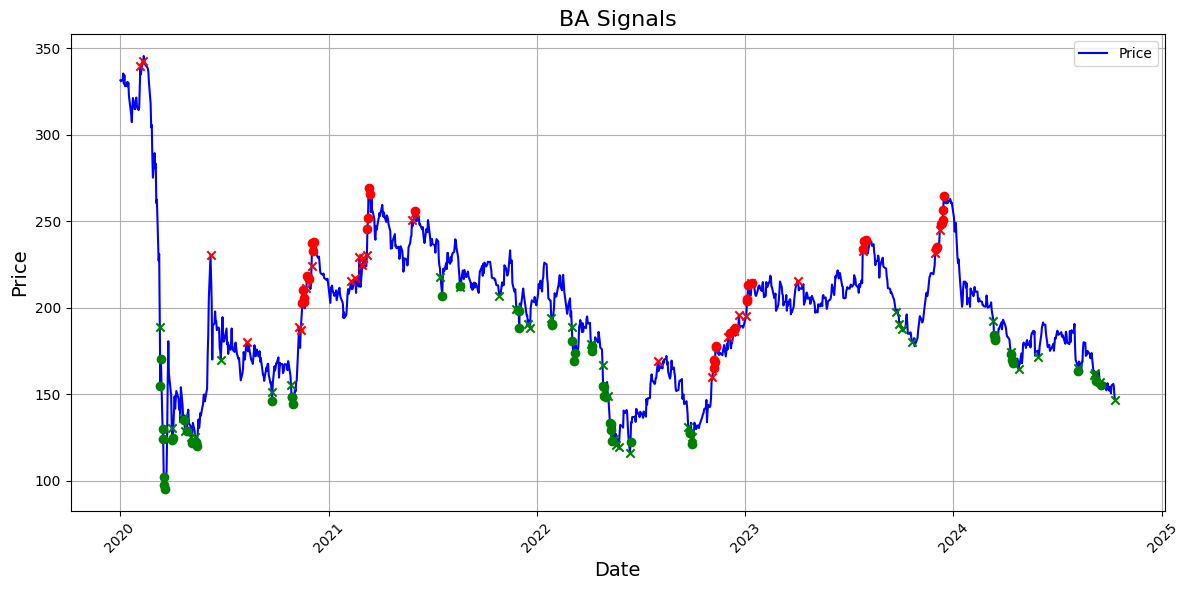

In [326]:
if __name__ == "__main__":

    ma_params = {
        5: 1.75,    # 2.5% for the 5-day MA
        10: 2.75,   # 3.0% for the 10-day MA
        15: 3.5,   # 3.5% for the 15-day MA
        20: 4,    # 4.0% for the 20-day MA
        100: 8.0    # 4.0% for the 20-day MA
    }
    breach_limit_alert = 4
    tickers = ['AAPL', 'NVDA', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'META', 'AVGO', 'TSLA', 'COST', 'ASML', 'NFLX', 'AMD', 'TMUS', 'AZN', 'PEP', 'LIN', 'ADBE', 'CSCO', 'PDD', 'QCOM', 'TXN', 'INTU', 'AMGN', 'ISRG', 'AMAT', 'CMCSA', 'ARM', 'BKNG', 'HON', 'VRTX', 'PANW', 'MU', 'ADP', 'ADI', 'REGN', 'KLAC', 'SBUX', 'LRCX', 'GILD', 'MELI', 'INTC', 'MDLZ', 'ABNB', 'CTAS', 'CEG', 'SNPS', 'PYPL', 'CRWD', 'CDNS', 'MAR', 'ORLY', 'CSX', 'WDAY', 'FTNT', 'MRVL', 'NXPI', 'ADSK', 'DASH', 'ROP', 'FANG', 'TTD', 'PCAR', 'CPRT', 'AEP', 'PAYX', 'MNST', 'KDP', 'TEAM', 'CHTR', 'ROST', 'DDOG', 'KHC', 'ODFL', 'MCHP', 'GEHC', 'FAST', 'EXC', 'IDXX', 'VRSK', 'EA', 'BKR', 'CTSH', 'CCEP', 'XEL', 'LULU', 'CSGP', 'ON', 'ZS', 'CDW', 'ANSS', 'DXCM', 'BIIB', 'TTWO', 'ILMN', 'GFS', 'MRNA', 'MDB', 'WBD', 'DLTR', 'WBA', 'LLY', 'WMT', 'JPM', 'BRK-B', 'UNH', 'ORCL', 'XOM', 'V', 'MA', 'HD', 'PG', 'JNJ', 'ABBV', 'BAC', 'KO', 'MRK', 'CVX', 'ACN', 'TMO', 'MCD', 'IBM', 'ABT', 'WFC', 'AXP', 'CAT', 'PM', 'VZ', 'MS', 'PFE', 'DIS', 'RTX', 'GS', 'T', 'LOW', 'UNP', 'LMT', 'COP', 'C', 'MDT', 'BMY', 'NKE', 'UPS', 'SO', 'BA', 'MO', 'CVS', 'CL', 'GD', 'MMM', 'TGT', 'USB', 'FCX', 'FDX', 'EMR', 'WMB', 'MET', 'COF', 'NSC', 'SPG', 'BK', 'GM', 'AIG', 'F', 'DOW', 'HPQ', 'EBAY', 'HAL', 'DVN', 'BAX']

    # data = read_data(tickers=tickers, start_date=dt.date(2020,1,1))
    # results, results_summarised = run_ma_analysis(tickers=tickers, ma_params=ma_params, breach_limit_alert=breach_limit_alert, data=data)

    # Write results to file.
    # final_results = results_summarised.loc[results_summarised['Signal']!=""]
    # final_results["Total_Breach_ABS"] = final_results["Total_Breach"].abs()
    # final_results.to_csv("
    #
    # ts/ma_index_tickers_" + dt.datetime.today().strftime('%Y-%m-%d') + ".csv")


    plot_signals(results=results, ticker="BA")

    final_results

In [ ]:
results_recent_clean

In [ ]:
get_cols_by_substring(results["AMZN"], "MA").mean()

In [ ]:
get_cols_by_substring(results["AMZN"], "MA").quantile(.9)

In [ ]:
get_cols_by_substring(results["AMZN"], "MA").quantile(.9).round(2).to_dict()

# Dashboard: Presenting the Results

In [323]:
# print(final_results)

def run_dashboard():
    st.set_page_config(layout="wide")
    st.title("Macro Indicators - UK")

    st.subheader('Index Signals across SP100 and Nasdaq 100')

    with st.expander("Data"):
        st.dataframe(
            final_results.sort_values(["Signal", "Total_Breach_ABS"], ascending=[True, False])
        )

run_dashboard()


In [325]:
final_results.sort_values(["Signal", "Total_Breach_ABS"], ascending=[True, False])

,Ticker,Price,Total_Breach,Signal,Total_Breach_ABS
Date,,,,,
2024-10-10,BA,146.619995,-5,BUY,5
2024-10-10,MRNA,56.830002,-5,BUY,5
2024-10-10,WBD,7.540000,-4,BUY,4
2024-10-10,AVGO,185.690002,5,SELL,5
2024-10-10,DDOG,130.089996,5,SELL,5
2024-10-10,FTNT,82.480003,5,SELL,5
2024-10-10,ILMN,143.759995,5,SELL,5
2024-10-10,MDB,292.690002,5,SELL,5
2024-10-10,NVDA,134.809998,5,SELL,5


In [341]:
results

{'AAPL':            Ticker       Price         MA5  Delta_MA5_Pct  MA5_Breach  \
 Date                                                                   
 2020-01-02   AAPL   72.876114   72.750421       0.172773           0   
 2020-01-03   AAPL   72.167610   72.750421      -0.801110           0   
 2020-01-06   AAPL   72.742645   72.750421      -0.010688           0   
 2020-01-07   AAPL   72.400543   72.750421      -0.480929           0   
 2020-01-08   AAPL   73.565193   72.750421       1.119955           0   
 ...           ...         ...         ...            ...         ...   
 2024-10-04   AAPL  226.800003  227.692001      -0.391757           0   
 2024-10-07   AAPL  221.690002  225.430002      -1.659051           0   
 2024-10-08   AAPL  225.770004  225.342001       0.189935           0   
 2024-10-09   AAPL  229.539993  225.894000       1.614028           0   
 2024-10-10   AAPL  229.039993  226.567999       1.091061           0   
 
                   MA10  Delta_MA10_Pct  

In [357]:
final_results

,Ticker,Price,Total_Breach,Signal,Total_Breach_ABS
Date,,,,,
2024-10-10,ARM,149.330002,4,SELL,4
2024-10-10,AVGO,185.690002,5,SELL,5
2024-10-10,BA,146.619995,-5,BUY,5
2024-10-10,CPRT,55.599998,4,SELL,4
2024-10-10,CRWD,314.920013,4,SELL,4
2024-10-10,CVS,66.849998,4,SELL,4
2024-10-10,DDOG,130.089996,5,SELL,5
2024-10-10,FTNT,82.480003,5,SELL,5
2024-10-10,IBM,233.020004,4,SELL,4


In [362]:
results.values()

170

In [352]:
results_df = pd.concat(results.values(), ignore_index=True)
results_df.reset_index()

,index,Ticker,Price,MA5,Delta_MA5_Pct,MA5_Breach,MA10,Delta_MA10_Pct,MA10_Breach,MA15,Delta_MA15_Pct,MA15_Breach,MA20,Delta_MA20_Pct,MA20_Breach,MA100,Delta_MA100_Pct,MA100_Breach,Total_Breach,Signal
0,0,AAPL,72.876114,72.750421,0.172773,0,74.249435,-1.849604,0,75.178250,-3.062237,0,75.711689,-3.745228,0,71.006867,2.632488,0,0,
1,1,AAPL,72.167610,72.750421,-0.801110,0,74.249435,-2.803825,-1,75.178250,-4.004669,-1,75.711689,-4.681019,-1,71.006867,1.634692,0,-3,
2,2,AAPL,72.742645,72.750421,-0.010688,0,74.249435,-2.029361,0,75.178250,-3.239773,0,75.711689,-3.921513,0,71.006867,2.444522,0,0,
3,3,AAPL,72.400543,72.750421,-0.480929,0,74.249435,-2.490108,0,75.178250,-3.694828,-1,75.711689,-4.373361,-1,71.006867,1.962735,0,-2,
4,4,AAPL,73.565193,72.750421,1.119955,0,74.249435,-0.921544,0,75.178250,-2.145643,0,75.711689,-2.835092,0,71.006867,3.602928,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204335,204335,ZS,173.929993,170.236002,2.169924,1,171.456999,1.442340,0,171.365334,1.496603,0,169.201001,2.794896,0,180.589300,-3.687543,0,1,
204336,204336,ZS,172.130005,170.474002,0.971411,0,171.191000,0.548513,0,171.388668,0.432547,0,169.849501,1.342661,0,180.542400,-4.659512,0,0,
204337,204337,ZS,176.929993,172.462000,2.590712,1,171.469000,3.184828,1,171.829333,2.968445,0,170.901001,3.527769,0,180.500400,-1.978061,0,2,
204338,204338,ZS,185.970001,175.717999,5.834349,1,172.891000,7.564882,1,172.992667,7.501667,1,172.114001,8.050478,1,180.567000,2.992242,0,4,SELL


In [385]:
results_df = pd.concat(results.values(), ignore_index=False).reset_index()
results_df

,Date,Ticker,Price,MA5,Delta_MA5_Pct,MA5_Breach,MA10,Delta_MA10_Pct,MA10_Breach,MA15,Delta_MA15_Pct,MA15_Breach,MA20,Delta_MA20_Pct,MA20_Breach,MA100,Delta_MA100_Pct,MA100_Breach,Total_Breach,Signal
0,2020-01-02,AAPL,72.876114,72.750421,0.172773,0,74.249435,-1.849604,0,75.178250,-3.062237,0,75.711689,-3.745228,0,71.006867,2.632488,0,0,
1,2020-01-03,AAPL,72.167610,72.750421,-0.801110,0,74.249435,-2.803825,-1,75.178250,-4.004669,-1,75.711689,-4.681019,-1,71.006867,1.634692,0,-3,
2,2020-01-06,AAPL,72.742645,72.750421,-0.010688,0,74.249435,-2.029361,0,75.178250,-3.239773,0,75.711689,-3.921513,0,71.006867,2.444522,0,0,
3,2020-01-07,AAPL,72.400543,72.750421,-0.480929,0,74.249435,-2.490108,0,75.178250,-3.694828,-1,75.711689,-4.373361,-1,71.006867,1.962735,0,-2,
4,2020-01-08,AAPL,73.565193,72.750421,1.119955,0,74.249435,-0.921544,0,75.178250,-2.145643,0,75.711689,-2.835092,0,71.006867,3.602928,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204335,2024-10-04,ZS,173.929993,170.236002,2.169924,1,171.456999,1.442340,0,171.365334,1.496603,0,169.201001,2.794896,0,180.589300,-3.687543,0,1,
204336,2024-10-07,ZS,172.130005,170.474002,0.971411,0,171.191000,0.548513,0,171.388668,0.432547,0,169.849501,1.342661,0,180.542400,-4.659512,0,0,
204337,2024-10-08,ZS,176.929993,172.462000,2.590712,1,171.469000,3.184828,1,171.829333,2.968445,0,170.901001,3.527769,0,180.500400,-1.978061,0,2,
204338,2024-10-09,ZS,185.970001,175.717999,5.834349,1,172.891000,7.564882,1,172.992667,7.501667,1,172.114001,8.050478,1,180.567000,2.992242,0,4,SELL


In [388]:
results_df.groupby("Ticker").max()

,Date,Price,MA5,Delta_MA5_Pct,MA5_Breach,MA10,Delta_MA10_Pct,MA10_Breach,MA15,Delta_MA15_Pct,MA15_Breach,MA20,Delta_MA20_Pct,MA20_Breach,MA100,Delta_MA100_Pct,MA100_Breach,Total_Breach,Signal
Ticker,,,,,,,,,,,,,,,,,,,
AAPL,2024-10-10,234.548523,231.793701,9.421751,1,229.355522,11.819930,1,227.214666,13.710122,1,225.669499,14.749331,1,217.238861,47.130344,1,5,SELL
ABBV,2024-10-10,199.350006,196.807999,8.252393,1,196.539998,10.882974,1,196.238665,12.722043,1,195.949998,13.526248,1,180.817707,25.500570,1,5,SELL
ABNB,2024-10-10,216.839996,210.600000,14.535783,1,204.775999,17.399899,1,201.358666,18.763793,1,198.375499,22.919904,1,178.024500,35.074778,1,5,SELL
ABT,2024-10-10,134.358398,133.894873,9.214279,1,132.315364,12.407417,1,131.198082,16.353211,1,130.472277,21.371423,1,121.774402,18.236294,1,5,SELL
ACN,2024-10-10,397.036926,396.520844,10.736262,1,390.909644,9.829816,1,385.077344,10.622896,1,378.344412,11.237175,1,349.259279,19.682549,1,5,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WMB,2024-10-10,49.680000,49.460001,16.040960,1,48.032000,16.318616,1,47.212667,20.632082,1,46.713000,26.737072,1,43.212842,26.311124,1,5,SELL
WMT,2024-10-10,81.400002,80.764000,8.142917,1,80.592000,9.532735,1,80.253333,9.813172,1,80.034000,11.215694,1,71.931300,18.266132,1,5,SELL
XEL,2024-10-10,71.712494,71.251149,8.295256,1,70.736070,9.097201,1,70.322896,13.530463,1,70.374776,11.841500,1,67.325557,15.334033,1,5,SELL


In [391]:
results_df.groupby('Ticker')['Date'].max()

Ticker
AAPL   2024-10-10
ABBV   2024-10-10
ABNB   2024-10-10
ABT    2024-10-10
ACN    2024-10-10
          ...    
WMB    2024-10-10
WMT    2024-10-10
XEL    2024-10-10
XOM    2024-10-10
ZS     2024-10-10
Name: Date, Length: 170, dtype: datetime64[ns]

In [394]:
results_df.loc[(results_df["Date"] == results_df["Date"].max())]

,Date,Ticker,Price,MA5,Delta_MA5_Pct,MA5_Breach,MA10,Delta_MA10_Pct,MA10_Breach,MA15,Delta_MA15_Pct,MA15_Breach,MA20,Delta_MA20_Pct,MA20_Breach,MA100,Delta_MA100_Pct,MA100_Breach,Total_Breach,Signal
1201,2024-10-10,AAPL,229.039993,226.567999,1.091061,0,227.228999,0.796991,0,227.214666,0.803349,0,225.669499,1.493553,0,217.238861,5.432330,0,0,
2403,2024-10-10,ABBV,194.350006,194.001999,0.179383,0,195.150999,-0.410448,0,194.365332,-0.007885,0,194.271499,0.040411,0,180.817707,7.483946,0,0,
3605,2024-10-10,ABNB,132.809998,132.176001,0.479661,0,129.288000,2.724148,0,129.635333,2.448919,0,127.656000,4.037411,1,134.559500,-1.300170,0,1,
4807,2024-10-10,ABT,115.620003,114.439999,1.031111,0,113.807000,1.593050,0,113.684000,1.702969,0,114.322499,1.134950,0,108.270847,6.787751,0,0,
6009,2024-10-10,ACN,361.070007,359.942828,0.313155,0,356.521790,1.275719,0,351.080280,2.845425,0,348.571162,3.585737,0,320.207174,12.761374,1,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199531,2024-10-10,WMB,49.470001,49.460001,0.020220,0,48.032000,2.993839,1,47.212667,4.781204,1,46.713000,5.902000,1,43.212842,14.479862,1,4,SELL
200733,2024-10-10,WMT,79.610001,79.952000,-0.427756,0,80.242000,-0.787616,0,80.253333,-0.801627,0,80.031499,-0.526666,0,71.931300,10.675047,1,1,
201935,2024-10-10,XEL,62.160000,62.882000,-1.148183,0,63.915001,-2.745835,0,63.972000,-2.832490,0,64.045000,-2.943243,0,57.806141,7.531828,0,0,
203137,2024-10-10,XOM,123.139999,123.494000,-0.286654,0,121.454000,1.388179,0,119.452667,3.086857,0,118.020500,4.337805,1,114.905210,7.166593,0,1,


In [ ]:
results_df.loc[(results_df["Date"] == results_df["Date"].max()) ]